<a href="https://colab.research.google.com/github/p2llo/Assignment1/blob/main/ADL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
jawadali1045_20k_multi_class_crop_disease_images_path = kagglehub.dataset_download('jawadali1045/20k-multi-class-crop-disease-images')

print('Data source import complete.')


In [ ]:
# Cell 1 — Imports and basic config
import os
import glob
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import json
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Paths (update only if your mounted folder name is different)
DATA_ROOT = "/kaggle/input/20k-multi-class-crop-disease-images"
WORK_DIR = "/kaggle/working/vae_outputs"
os.makedirs(WORK_DIR, exist_ok=True)

print("DATA_ROOT =", DATA_ROOT)
print("WORK_DIR =", WORK_DIR)


DATA_ROOT = /kaggle/input/20k-multi-class-crop-disease-images
WORK_DIR = /kaggle/working/vae_outputs


In [ ]:
# Cell 2 — Quick listing to confirm structure (run this to see exact top-level folders)
print("Top-level entries in /kaggle/input:")
print(os.listdir("/kaggle/input"))
print("\nEntries in dataset root:")
print(os.listdir(DATA_ROOT)[:30])


Top-level entries in /kaggle/input:
['20k-multi-class-crop-disease-images']

Entries in dataset root:
['Validation', 'Train']


In [ ]:
# Cell 3 — Dataset class: recursively reads all class subfolders under each top-level folder
IMAGE_SIZE = 128
BATCH_SIZE = 32

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),            # [0,1]
])

class Crop20KDataset(Dataset):
    def __init__(self, root, transform=None, exts=(".jpg",".jpeg",".png",".JPG",".JPEG")):
        self.transform = transform
        self.files = []
        self.labels = []   # optional if you later want labels
        self.class_to_idx = {}
        self.idx_to_class = {}
        class_idx = 0

        # iterate over top-level folders in dataset root
        top_folders = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
        for top in top_folders:
            top_path = os.path.join(root, top)
            # list class folders inside this top folder
            for cls in os.listdir(top_path):
                cls_path = os.path.join(top_path, cls)
                if not os.path.isdir(cls_path):
                    continue
                if cls not in self.class_to_idx:
                    self.class_to_idx[cls] = class_idx
                    self.idx_to_class[class_idx] = cls
                    class_idx += 1
                files = []
                for ext in exts:
                    files.extend(glob.glob(os.path.join(cls_path, f"*{ext}")))
                for f in files:
                    self.files.append(f)
                    self.labels.append(self.class_to_idx[cls])

        # shuffle for safety
        temp = list(zip(self.files, self.labels))
        random.shuffle(temp)
        self.files, self.labels = zip(*temp)
        self.files = list(self.files)
        self.labels = list(self.labels)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        # return image, label (label optional)
        return img, self.labels[idx]

# Instantiate dataset and dataloader
dataset = Crop20KDataset(DATA_ROOT, transform=transform)
print("Total images found:", len(dataset))
print("Num classes discovered:", len(dataset.class_to_idx))

# DataLoader
num_workers = 2
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True)


Total images found: 18503
Num classes discovered: 44


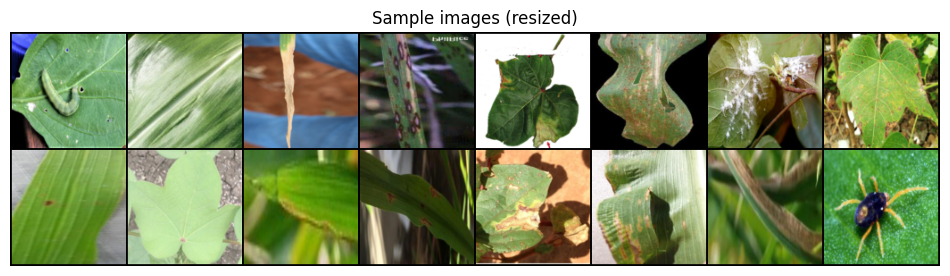

In [ ]:
# Cell 4 — Utility: show a small grid of images (sanity check)
def show_grid(imgs, nrow=8, title=None):
    grid = utils.make_grid(imgs, nrow=nrow, padding=2)
    plt.figure(figsize=(12,6))
    plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
    if title: plt.title(title)
    plt.axis('off')
    plt.show()

# show sample batch
imgs, labs = next(iter(dataloader))
show_grid(imgs[:16], nrow=8, title="Sample images (resized)")


In [ ]:
# Cell 5 — VAE model (Encoder, Decoder, VAE wrapper)
class Encoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),    # 64x64
            nn.Conv2d(32, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),   # 32x32
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(inplace=True), # 16x16
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),# 8x8
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),# 4x4
        )
        self.flatten_dim = 512 * 4 * 4
        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 512 * 4 * 4)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(inplace=True), # 8x8
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(inplace=True), # 16x16
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),   # 32x32
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),    # 64x64
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Sigmoid()                                    # 128x128
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 512, 4, 4)
        x = self.deconv(x)
        return x

class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar


In [ ]:
# Cell 6 — Loss function (reconstruction + KL)
def vae_loss(x_hat, x, mu, logvar, recon_weight=1.0):
    # Reconstruction: MSE (suitable for [0,1] images). Sum over pixels then mean per batch sample.
    recon = F.mse_loss(x_hat, x, reduction='sum') / x.size(0)
    # KL divergence between q(z|x)=N(mu, sigma^2) and p(z)=N(0,I)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    loss = recon_weight * recon + kld
    return loss, recon, kld


In [ ]:
# Cell 7 — Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

latent_dim = 64
model = VAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
EPOCHS = 12           # adjust as needed; Kaggle GPU sessions have time limits
log_interval = 100

# Optionally: KL annealing schedule (linear)
kl_anneal_steps = len(dataloader) * 5  # warmup for first 5 epochs worth of iterations
global_step = 0


Using device: cpu


In [ ]:
# Cell 8 — Training loop with checkpointing
best_loss = float('inf')
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    running_recon = 0.0
    running_kld = 0.0
    for batch_idx, (imgs, _) in enumerate(tqdm(dataloader)):
        imgs = imgs.to(device)
        optimizer.zero_grad()
        x_hat, mu, logvar = model(imgs)

        # KL weight for annealing
        if kl_anneal_steps > 0:
            kl_weight = min(1.0, global_step / kl_anneal_steps)
        else:
            kl_weight = 1.0

        loss, recon, kld = vae_loss(x_hat, imgs, mu, logvar)
        # apply annealing by scaling KLD (equivalently we could multiply kld by kl_weight)
        loss = recon + kl_weight * (kld)  # keep recon + weighted kld
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_recon += recon.item()
        running_kld += kld.item()
        global_step += 1

        if (batch_idx + 1) % log_interval == 0:
            print(f"Epoch {epoch} [{batch_idx+1}/{len(dataloader)}]  "
                  f"Loss: {running_loss/(batch_idx+1):.4f}  Recon: {running_recon/(batch_idx+1):.4f}  KLD: {running_kld/(batch_idx+1):.4f}  KLw: {kl_weight:.3f}")

    avg_loss = running_loss / len(dataloader)
    print(f"Epoch {epoch} completed. Avg Loss: {avg_loss:.4f}  Avg Recon: {running_recon/len(dataloader):.4f}  Avg KLD: {running_kld/len(dataloader):.4f}")

    # Save checkpoint
    ckpt_path = os.path.join(WORK_DIR, f"vae_epoch{epoch}.pth")
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": avg_loss,
    }, ckpt_path)
    print("Saved checkpoint:", ckpt_path)

    # update best
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_path = os.path.join(WORK_DIR, "vae_best.pth")
        torch.save(model.state_dict(), best_path)
        print("Saved best model to:", best_path)


 17%|█▋        | 100/579 [01:33<07:26,  1.07it/s]

Epoch 1 [100/579]  Loss: 2165.2857  Recon: 2155.5981  KLD: 2328.4566  KLw: 0.034


 35%|███▍      | 200/579 [03:07<05:46,  1.09it/s]

Epoch 1 [200/579]  Loss: 1731.9911  Recon: 1721.8792  KLD: 1266.2755  KLw: 0.069


 52%|█████▏    | 300/579 [04:40<04:15,  1.09it/s]

Epoch 1 [300/579]  Loss: 1511.2824  Recon: 1498.8408  KLD: 910.5002  KLw: 0.103


 69%|██████▉   | 400/579 [06:12<02:44,  1.09it/s]

Epoch 1 [400/579]  Loss: 1373.4518  Recon: 1358.3834  KLD: 730.4284  KLw: 0.138


 77%|███████▋  | 447/579 [06:55<01:59,  1.11it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 82%|████████▏ | 475/579 [07:21<01:39,  1.05it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 86%|████████▋ | 500/579 [07:44<01:14,  1.06it/s]

Epoch 1 [500/579]  Loss: 1277.5968  Recon: 1259.9742  KLD: 620.2589  KLw: 0.172


100%|██████████| 579/579 [08:57<00:00,  1.08it/s]


Epoch 1 completed. Avg Loss: 1219.5397  Avg Recon: 1199.9669  Avg KLD: 559.0365
Saved checkpoint: /kaggle/working/vae_outputs/vae_epoch1.pth
Saved best model to: /kaggle/working/vae_outputs/vae_best.pth


 17%|█▋        | 100/579 [01:30<07:42,  1.04it/s]

Epoch 2 [100/579]  Loss: 823.0140  Recon: 787.6416  KLD: 163.0262  KLw: 0.234


 29%|██▉       | 167/579 [02:30<06:21,  1.08it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 35%|███▍      | 200/579 [02:59<05:36,  1.13it/s]

Epoch 2 [200/579]  Loss: 813.5377  Recon: 776.1319  KLD: 159.8964  KLw: 0.269


 52%|█████▏    | 300/579 [04:30<04:04,  1.14it/s]

Epoch 2 [300/579]  Loss: 809.2539  Recon: 769.9177  KLD: 156.9344  KLw: 0.303


 69%|██████▉   | 400/579 [06:00<02:56,  1.01it/s]

Epoch 2 [400/579]  Loss: 802.9043  Recon: 761.6143  KLD: 154.4584  KLw: 0.338


 79%|███████▉  | 458/579 [06:51<01:58,  1.02it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 86%|████████▋ | 500/579 [07:29<01:11,  1.10it/s]

Epoch 2 [500/579]  Loss: 798.6087  Recon: 755.4026  KLD: 152.2077  KLw: 0.372


100%|██████████| 579/579 [08:39<00:00,  1.12it/s]


Epoch 2 completed. Avg Loss: 796.5220  Avg Recon: 751.8021  Avg KLD: 150.6283
Saved checkpoint: /kaggle/working/vae_outputs/vae_epoch2.pth
Saved best model to: /kaggle/working/vae_outputs/vae_best.pth


 17%|█▋        | 100/579 [01:30<07:02,  1.13it/s]

Epoch 3 [100/579]  Loss: 762.1951  Recon: 704.9829  KLD: 137.1804  KLw: 0.434


 35%|███▍      | 200/579 [02:58<05:26,  1.16it/s]

Epoch 3 [200/579]  Loss: 754.9335  Recon: 695.9474  KLD: 135.8638  KLw: 0.469


 52%|█████▏    | 300/579 [04:26<03:58,  1.17it/s]

Epoch 3 [300/579]  Loss: 755.1109  Recon: 694.2029  KLD: 134.9760  KLw: 0.503


 69%|██████▉   | 400/579 [05:57<02:53,  1.03it/s]

Epoch 3 [400/579]  Loss: 753.0564  Recon: 690.3687  KLD: 133.8992  KLw: 0.538


 81%|████████  | 467/579 [06:55<01:31,  1.23it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 86%|████████▋ | 500/579 [07:24<01:08,  1.15it/s]

Epoch 3 [500/579]  Loss: 751.5704  Recon: 686.9153  KLD: 133.2438  KLw: 0.572


 94%|█████████▍| 546/579 [08:04<00:33,  1.02s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 579/579 [08:33<00:00,  1.13it/s]


Epoch 3 completed. Avg Loss: 751.1030  Avg Recon: 685.0676  Avg KLD: 132.4672
Saved checkpoint: /kaggle/working/vae_outputs/vae_epoch3.pth
Saved best model to: /kaggle/working/vae_outputs/vae_best.pth


  9%|▉         | 55/579 [00:49<07:15,  1.20it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 17%|█▋        | 100/579 [01:29<06:38,  1.20it/s]

Epoch 4 [100/579]  Loss: 723.5532  Recon: 646.0787  KLD: 125.5550  KLw: 0.634


 35%|███▍      | 200/579 [02:58<06:02,  1.05it/s]

Epoch 4 [200/579]  Loss: 724.7094  Recon: 645.8343  KLD: 124.3773  KLw: 0.669


 52%|█████▏    | 300/579 [04:30<04:23,  1.06it/s]

Epoch 4 [300/579]  Loss: 723.8116  Recon: 643.3903  KLD: 123.4899  KLw: 0.703


 69%|██████▉   | 400/579 [06:00<02:52,  1.04it/s]

Epoch 4 [400/579]  Loss: 724.8569  Recon: 642.9539  KLD: 122.5730  KLw: 0.738


 83%|████████▎ | 482/579 [07:13<01:24,  1.15it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 86%|████████▋ | 500/579 [07:28<01:05,  1.21it/s]

Epoch 4 [500/579]  Loss: 725.9116  Recon: 642.5764  KLD: 121.6442  KLw: 0.772


100%|██████████| 579/579 [08:37<00:00,  1.12it/s]


Epoch 4 completed. Avg Loss: 727.1329  Avg Recon: 642.6486  Avg KLD: 120.9731
Saved checkpoint: /kaggle/working/vae_outputs/vae_epoch4.pth
Saved best model to: /kaggle/working/vae_outputs/vae_best.pth


 17%|█▋        | 100/579 [01:47<07:24,  1.08it/s]

Epoch 5 [100/579]  Loss: 718.6205  Recon: 624.1559  KLD: 115.6211  KLw: 0.834


 35%|███▍      | 200/579 [03:17<05:22,  1.17it/s]

Epoch 5 [200/579]  Loss: 722.2435  Recon: 626.7356  KLD: 114.4986  KLw: 0.869


 52%|█████▏    | 300/579 [04:49<04:27,  1.04it/s]

Epoch 5 [300/579]  Loss: 726.5291  Recon: 629.6739  KLD: 113.7763  KLw: 0.903


 64%|██████▍   | 370/579 [05:54<03:01,  1.15it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 69%|██████▉   | 400/579 [06:21<02:30,  1.19it/s]

Epoch 5 [400/579]  Loss: 726.1308  Recon: 628.2137  KLD: 112.7844  KLw: 0.938


 75%|███████▌  | 435/579 [06:54<02:19,  1.03it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 86%|████████▋ | 500/579 [07:56<01:16,  1.04it/s]

Epoch 5 [500/579]  Loss: 728.1673  Recon: 629.1288  KLD: 111.9036  KLw: 0.972


100%|██████████| 579/579 [09:10<00:00,  1.05it/s]


Epoch 5 completed. Avg Loss: 728.5643  Avg Recon: 628.5810  Avg KLD: 111.2961
Saved checkpoint: /kaggle/working/vae_outputs/vae_epoch5.pth


 17%|█▋        | 100/579 [01:36<12:04,  1.51s/it]

Epoch 6 [100/579]  Loss: 720.3209  Recon: 612.8397  KLD: 107.4812  KLw: 1.000


 35%|███▍      | 200/579 [03:17<05:23,  1.17it/s]

Epoch 6 [200/579]  Loss: 719.4788  Recon: 612.3449  KLD: 107.1339  KLw: 1.000


 49%|████▉     | 283/579 [04:31<04:14,  1.16it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 52%|█████▏    | 300/579 [04:46<04:26,  1.05it/s]

Epoch 6 [300/579]  Loss: 720.9481  Recon: 614.0149  KLD: 106.9332  KLw: 1.000


 69%|██████▉   | 400/579 [06:19<02:40,  1.12it/s]

Epoch 6 [400/579]  Loss: 725.3731  Recon: 618.5443  KLD: 106.8288  KLw: 1.000


 86%|████████▋ | 500/579 [07:53<01:15,  1.04it/s]

Epoch 6 [500/579]  Loss: 723.3758  Recon: 616.7185  KLD: 106.6573  KLw: 1.000


 95%|█████████▌| 552/579 [08:41<00:24,  1.12it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
100%|██████████| 579/579 [09:11<00:00,  1.05it/s]


Epoch 6 completed. Avg Loss: 724.2615  Avg Recon: 617.7134  Avg KLD: 106.5481
Saved checkpoint: /kaggle/working/vae_outputs/vae_epoch6.pth
Saved best model to: /kaggle/working/vae_outputs/vae_best.pth


 17%|█▋        | 100/579 [01:32<07:26,  1.07it/s]

Epoch 7 [100/579]  Loss: 709.5212  Recon: 602.3322  KLD: 107.1890  KLw: 1.000


 35%|███▍      | 200/579 [03:11<08:17,  1.31s/it]

Epoch 7 [200/579]  Loss: 704.9642  Recon: 598.1793  KLD: 106.7849  KLw: 1.000


 52%|█████▏    | 300/579 [04:45<04:09,  1.12it/s]

Epoch 7 [300/579]  Loss: 705.9444  Recon: 599.4001  KLD: 106.5443  KLw: 1.000


 69%|██████▉   | 400/579 [06:19<02:44,  1.09it/s]

Epoch 7 [400/579]  Loss: 704.3999  Recon: 598.1991  KLD: 106.2008  KLw: 1.000


 76%|███████▋  | 442/579 [06:57<02:05,  1.09it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 80%|███████▉  | 462/579 [07:15<01:56,  1.00it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 86%|████████▋ | 500/579 [07:49<01:09,  1.13it/s]

Epoch 7 [500/579]  Loss: 707.2502  Recon: 601.0986  KLD: 106.1516  KLw: 1.000


100%|██████████| 579/579 [08:59<00:00,  1.07it/s]


Epoch 7 completed. Avg Loss: 708.7057  Avg Recon: 602.5116  Avg KLD: 106.1942
Saved checkpoint: /kaggle/working/vae_outputs/vae_epoch7.pth
Saved best model to: /kaggle/working/vae_outputs/vae_best.pth


 13%|█▎        | 74/579 [01:07<07:35,  1.11it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 17%|█▋        | 100/579 [01:31<07:28,  1.07it/s]

Epoch 8 [100/579]  Loss: 700.4451  Recon: 594.2361  KLD: 106.2091  KLw: 1.000


 35%|███▍      | 200/579 [03:00<05:29,  1.15it/s]

Epoch 8 [200/579]  Loss: 698.7573  Recon: 592.4582  KLD: 106.2991  KLw: 1.000


 52%|█████▏    | 300/579 [04:29<04:14,  1.10it/s]

Epoch 8 [300/579]  Loss: 699.0839  Recon: 592.8016  KLD: 106.2823  KLw: 1.000


 69%|██████▉   | 400/579 [06:00<02:36,  1.14it/s]

Epoch 8 [400/579]  Loss: 700.3755  Recon: 593.9984  KLD: 106.3771  KLw: 1.000


 86%|████████▋ | 500/579 [07:32<01:08,  1.15it/s]

Epoch 8 [500/579]  Loss: 700.2750  Recon: 593.9341  KLD: 106.3409  KLw: 1.000


 97%|█████████▋| 562/579 [08:28<00:14,  1.14it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 579/579 [08:43<00:00,  1.11it/s]


Epoch 8 completed. Avg Loss: 696.9507  Avg Recon: 590.7896  Avg KLD: 106.1611
Saved checkpoint: /kaggle/working/vae_outputs/vae_epoch8.pth
Saved best model to: /kaggle/working/vae_outputs/vae_best.pth


 17%|█▋        | 100/579 [01:34<07:29,  1.07it/s]

Epoch 9 [100/579]  Loss: 694.8314  Recon: 588.5289  KLD: 106.3024  KLw: 1.000


 35%|███▍      | 200/579 [03:05<05:41,  1.11it/s]

Epoch 9 [200/579]  Loss: 688.9652  Recon: 582.7971  KLD: 106.1682  KLw: 1.000


 44%|████▍     | 254/579 [03:55<04:42,  1.15it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 52%|█████▏    | 300/579 [04:39<04:16,  1.09it/s]

Epoch 9 [300/579]  Loss: 686.4314  Recon: 580.2521  KLD: 106.1794  KLw: 1.000


 60%|█████▉    | 345/579 [05:19<03:30,  1.11it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 69%|██████▉   | 400/579 [06:10<02:41,  1.11it/s]

Epoch 9 [400/579]  Loss: 687.5168  Recon: 581.5257  KLD: 105.9911  KLw: 1.000


 86%|████████▋ | 500/579 [07:41<01:09,  1.14it/s]

Epoch 9 [500/579]  Loss: 686.0196  Recon: 580.0202  KLD: 105.9994  KLw: 1.000


100%|██████████| 579/579 [08:51<00:00,  1.09it/s]


Epoch 9 completed. Avg Loss: 685.8753  Avg Recon: 579.8180  Avg KLD: 106.0574
Saved checkpoint: /kaggle/working/vae_outputs/vae_epoch9.pth
Saved best model to: /kaggle/working/vae_outputs/vae_best.pth


  1%|          | 3/579 [00:03<11:25,  1.19s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 17%|█▋        | 100/579 [01:30<07:18,  1.09it/s]

Epoch 10 [100/579]  Loss: 676.0707  Recon: 569.2839  KLD: 106.7868  KLw: 1.000


 35%|███▍      | 200/579 [03:03<05:37,  1.12it/s]

Epoch 10 [200/579]  Loss: 681.8265  Recon: 575.2326  KLD: 106.5939  KLw: 1.000


 41%|████▏     | 240/579 [03:40<05:00,  1.13it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 52%|█████▏    | 300/579 [04:35<04:39,  1.00s/it]

Epoch 10 [300/579]  Loss: 679.7449  Recon: 573.2540  KLD: 106.4909  KLw: 1.000


 69%|██████▉   | 400/579 [06:07<02:39,  1.12it/s]

Epoch 10 [400/579]  Loss: 678.8602  Recon: 572.5516  KLD: 106.3086  KLw: 1.000


 86%|████████▋ | 500/579 [07:38<01:13,  1.08it/s]

Epoch 10 [500/579]  Loss: 679.0672  Recon: 572.9146  KLD: 106.1527  KLw: 1.000


100%|██████████| 579/579 [08:50<00:00,  1.09it/s]


Epoch 10 completed. Avg Loss: 677.5542  Avg Recon: 571.4186  Avg KLD: 106.1356
Saved checkpoint: /kaggle/working/vae_outputs/vae_epoch10.pth
Saved best model to: /kaggle/working/vae_outputs/vae_best.pth


 17%|█▋        | 100/579 [01:45<13:39,  1.71s/it]

Epoch 11 [100/579]  Loss: 670.6042  Recon: 564.0705  KLD: 106.5336  KLw: 1.000


 35%|███▍      | 200/579 [03:20<06:44,  1.07s/it]

Epoch 11 [200/579]  Loss: 670.4221  Recon: 564.0621  KLD: 106.3600  KLw: 1.000


 52%|█████▏    | 300/579 [04:49<04:22,  1.06it/s]

Epoch 11 [300/579]  Loss: 669.1077  Recon: 562.5668  KLD: 106.5409  KLw: 1.000


 55%|█████▌    | 319/579 [05:07<03:56,  1.10it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 56%|█████▌    | 322/579 [05:10<04:22,  1.02s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 69%|██████▉   | 400/579 [06:25<02:34,  1.16it/s]

Epoch 11 [400/579]  Loss: 669.7505  Recon: 563.2368  KLD: 106.5137  KLw: 1.000


 86%|████████▋ | 500/579 [07:59<01:09,  1.14it/s]

Epoch 11 [500/579]  Loss: 669.1873  Recon: 562.8919  KLD: 106.2954  KLw: 1.000


100%|██████████| 579/579 [09:13<00:00,  1.05it/s]


Epoch 11 completed. Avg Loss: 669.0642  Avg Recon: 562.7847  Avg KLD: 106.2795
Saved checkpoint: /kaggle/working/vae_outputs/vae_epoch11.pth
Saved best model to: /kaggle/working/vae_outputs/vae_best.pth


 17%|█▋        | 100/579 [01:36<06:55,  1.15it/s]

Epoch 12 [100/579]  Loss: 669.1921  Recon: 562.2754  KLD: 106.9166  KLw: 1.000


 21%|██        | 119/579 [01:53<06:17,  1.22it/s]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 35%|███▍      | 200/579 [03:18<05:34,  1.13it/s]

Epoch 12 [200/579]  Loss: 663.1314  Recon: 556.5668  KLD: 106.5645  KLw: 1.000


 52%|█████▏    | 300/579 [04:47<04:09,  1.12it/s]

Epoch 12 [300/579]  Loss: 664.1423  Recon: 557.7260  KLD: 106.4164  KLw: 1.000


 69%|██████▉   | 400/579 [06:20<02:41,  1.11it/s]

Epoch 12 [400/579]  Loss: 664.5376  Recon: 558.1368  KLD: 106.4008  KLw: 1.000


 86%|████████▋ | 500/579 [07:53<01:09,  1.13it/s]

Epoch 12 [500/579]  Loss: 664.2858  Recon: 558.0017  KLD: 106.2841  KLw: 1.000


 93%|█████████▎| 541/579 [08:31<00:34,  1.12it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 579/579 [09:04<00:00,  1.06it/s]


Epoch 12 completed. Avg Loss: 664.3614  Avg Recon: 558.0898  Avg KLD: 106.2715
Saved checkpoint: /kaggle/working/vae_outputs/vae_epoch12.pth
Saved best model to: /kaggle/working/vae_outputs/vae_best.pth


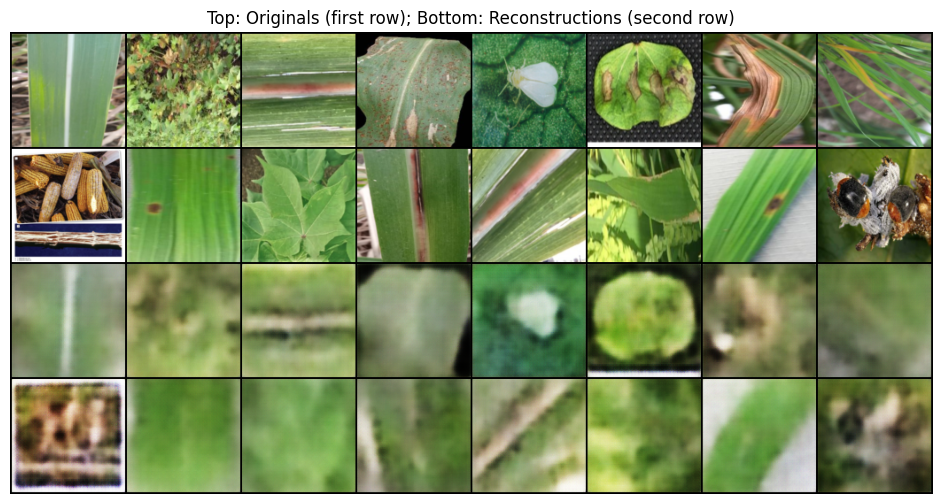

In [ ]:
# Cell 9 — Visualize reconstructions (first N samples of a batch)
model.eval()
imgs, _ = next(iter(dataloader))
imgs = imgs.to(device)[:16]
with torch.no_grad():
    x_hat, _, _ = model(imgs)

imgs_cpu = imgs.cpu()
xhat_cpu = x_hat.cpu()

# show originals and reconstructions side-by-side
n = imgs_cpu.size(0)
combined = torch.cat([imgs_cpu, xhat_cpu], dim=0)
show_grid(combined, nrow=8, title="Top: Originals (first row); Bottom: Reconstructions (second row)")


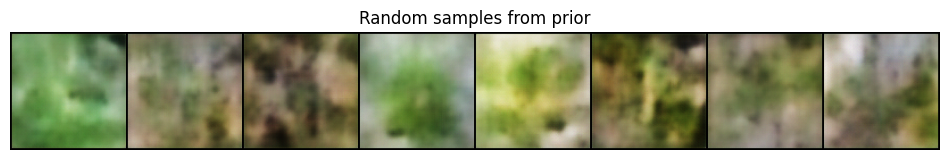

Saved random samples to: /kaggle/working/vae_outputs/random_samples_grid.png


In [ ]:
# Cell 10 — Generate random samples from prior
model.eval()
with torch.no_grad():
    z = torch.randn(8, latent_dim).to(device)
    samples = model.decoder(z).cpu()

show_grid(samples, nrow=8, title="Random samples from prior")
# Save sample grid
utils.save_image(samples, os.path.join(WORK_DIR, "random_samples_grid.png"), nrow=8)
print("Saved random samples to:", os.path.join(WORK_DIR, "random_samples_grid.png"))


 11%|█         | 62/579 [00:25<03:28,  2.48it/s]


Latents shape: (2000, 64) Labels shape: (2000,)


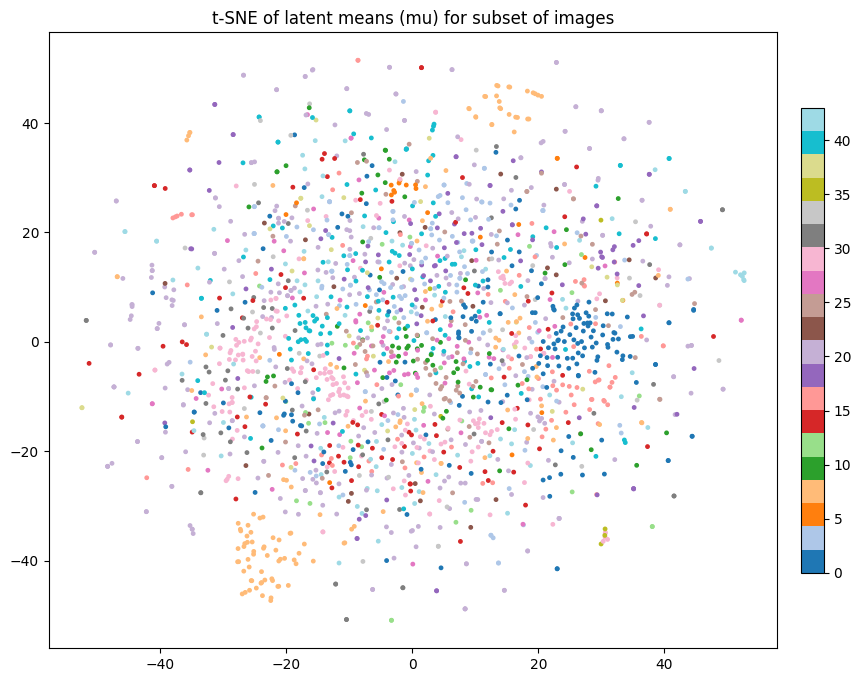

In [ ]:
# Cell 11 — Extract latent vectors for a subset and run t-SNE (visualization)
# We'll take up to 2000 images for speed. Install sklearn if missing.
try:
    from sklearn.manifold import TSNE
except Exception:
    !pip install scikit-learn
    from sklearn.manifold import TSNE

model.eval()
max_samples = 2000
latents = []
labels = []
count = 0
with torch.no_grad():
    for imgs, labs in tqdm(dataloader):
        imgs = imgs.to(device)
        mu, logvar = model.encoder(imgs)
        z = mu.cpu().numpy()               # use mu as deterministic embed
        latents.append(z)
        labels.extend(labs.numpy().tolist())
        count += z.shape[0]
        if count >= max_samples:
            break

latents = np.vstack(latents)[:max_samples]
labels = np.array(labels)[:max_samples]

print("Latents shape:", latents.shape, "Labels shape:", labels.shape)

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca', random_state=42)
lat2d = tsne.fit_transform(latents)

plt.figure(figsize=(10,8))
num_plot = min(2000, lat2d.shape[0])
# color by label (use a colormap)
scatter = plt.scatter(lat2d[:num_plot,0], lat2d[:num_plot,1], c=labels[:num_plot], s=6, cmap='tab20')
plt.colorbar(scatter, fraction=0.03, pad=0.03)
plt.title("t-SNE of latent means (mu) for subset of images")
plt.show()


In [ ]:
# Cell 12 — Save model and metadata for future use
torch.save(model.state_dict(), os.path.join(WORK_DIR, "vae_final.pth"))
with open(os.path.join(WORK_DIR, "class_mapping.json"), "w") as f:
    json.dump(dataset.class_to_idx, f)
print("Saved final model and class mapping to", WORK_DIR)


Saved final model and class mapping to /kaggle/working/vae_outputs
